In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# What is Semantic Segmentation?

Semantic segmentation is a computer vision task that involves labeling each pixel in an image with a corresponding class label, such as identifying objects like people, cars, flowers, or furniture. It's like doing image classification at a pixel level, assigning a category to every part of the image. This is different from instance segmentation, which distinguishes individual instances of objects. Semantic segmentation is useful in various applications, including counting objects in an image or understanding scene semantics.

## Data Augmenation:

During the initial phase of the segmentation process, data augmentation and preprocessing are performed.

### Regarding the Dataset
The Aerial Semantic Segmentation Drone Dataset comprises 400 aerial images captured by a high-quality drone camera. The images originally measure 6000 * 4000, necessitating resizing for computational efficiency. The images have been resized to 800 * 1200 dimensions. They are rescaled and converted to Float32 dtype, and the greyscale masks are transformed into Int32 dtype. The dataset includes binary and RGB label masks for each image.

### Running the import commands 


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
from sklearn.model_selection import train_test_split

### Original image

In [ ]:
img1=cv2.imread('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg')
plt.imshow(img1)

### Label

In [ ]:
img2=cv2.imread('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png')
plt.imshow(img2)

### Here's why we look at both the original image and the Label

In semantic segmentation, analyzing both the original image and its labeled counterpart is essential. This pairing is crucial for training models to recognize visual features associated with different classes, evaluating model performance, ensuring generalization to new data, debugging, and providing interpretability for users. The labeled images serve as supervision during training, guide performance assessment, and enable the model to generalize its understanding to diverse scenarios.

### RGB image 
In semantic segmentation, we analyze the RGB (Red, Green, Blue) image because it serves as the input data for the model. The RGB image provides the visual information and features necessary for the model to learn and classify each pixel into specific semantic classes. By examining the original image, the model understands the visual patterns associated with different objects or regions, enabling it to accurately segment and classify each pixel during training and inference.

In [ ]:
img3=cv2.imread('/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/000.png')
plt.imshow(img3)

### The following code defines a set of functions to read and preprocess images and masks for semantic segmentation. Here's a brief explanation:

1. `read_image(x)`:
   - Reads an image file (`x`) using OpenCV with color mode (RGB).
   - Resizes the image to the specified dimensions (W, H).
   - Normalizes pixel values to the range [0, 1].
   - Converts the image to a NumPy array with dtype float32.

2. `read_mask(x)`:
   - Reads a mask image file (`x`) using OpenCV in grayscale mode.
   - Resizes the mask to the specified dimensions (W, H).
   - Converts the mask to a NumPy array with dtype int32.

3. `tf_dataset(x, y, batch=4)`:
   - Creates a TensorFlow Dataset from image and mask file paths (x, y).
   - Shuffles the dataset with a buffer size of 100.
   - Maps the `preprocess` function to each element in the dataset.
   - Batches the dataset with the specified batch size.
   - Repeats the dataset indefinitely.
   - Prefetches 2 batches to optimize performance.

4. `preprocess(x, y)`:
   - Converts byte strings (`x` and `y`) to regular strings.
   - Applies the `read_image` and `read_mask` functions to load and preprocess the image and mask.
   - Converts the mask to one-hot encoding with a specified number of classes.
   - Sets the shapes of the image and mask tensors.

This code is part of a larger pipeline for preparing a dataset for semantic segmentation, including reading images and masks, normalizing pixel values, and setting up TensorFlow datasets for training a neural network.

In [ ]:
num_classes=23
H=800
W=1200

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32) ##image dtype is Float32
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32) ##mask dtype is Int32
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)) # Dataset data object created from input and target data
    dataset = dataset.shuffle(buffer_size=100) ## selected from the first 100 samples
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine batch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization to reduce waiting time on each object
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode() ##byte stream conversion
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

### Specifying paths for images and masks, along with creating a list of labels, is crucial for organizing and linking input data in semantic segmentation:

1. **Data Location:**
   - **Image and Mask Paths:** Specify the file paths where the images and corresponding masks are stored. This enables the program to locate and load the data during processing.

2. **Labeling:**
   - **Labels List:** Create a list of labels to associate each image with its semantic class. This is essential for training the model to recognize and classify different objects in the images.

3. **Dataset Construction:**
   - **TensorFlow Dataset:** Use the specified paths and labels to construct a TensorFlow Dataset. This dataset is a structured input for training machine learning models, facilitating efficient processing and learning.

4. **Training Supervision:**
   - **Path-Label Pairing:** During training, the model learns from pairs of images and masks. The list of labels ensures that the model understands the correspondence between visual features and semantic classes.

5. **Data Organization:**
   - **Structured Lists:** Organizing paths and labels in lists simplifies the handling of datasets, providing clarity and structure for accessing and processing data throughout the model's lifecycle.

In [ ]:
root_dir = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset'
img_path = root_dir + '/original_images/'
mask_path = root_dir + '/label_images_semantic/'

names = list(map(lambda x: x.replace('.jpg', ''), os.listdir(img_path)))

### Splitting mask data and image data into train, validation, and test sets is crucial in semantic segmentation for the following reasons:

1. **Training and Evaluation:**
   - **Train Set:** The training set is used to train the model, allowing it to learn the relationships between input images and corresponding masks, ultimately improving its ability to perform segmentation.
   - **Validation Set:** The validation set is employed during training to assess the model's performance on unseen data. It helps in tuning hyperparameters and preventing overfitting.

2. **Model Generalization:**
   - **Test Set:** The test set is reserved for evaluating the model's performance on completely new and unseen data. This ensures that the model generalizes well and provides a reliable indication of its real-world performance.

3. **Preventing Data Leakage:**
   - **Independent Sets:** By having distinct training, validation, and test sets, we avoid any data leakage between the sets. Each set serves a specific purpose without unintentional overlap, ensuring a fair evaluation of the model's performance.

4. **Hyperparameter Tuning:**
   - **Validation Set Usage:** The validation set aids in fine-tuning the model by adjusting hyperparameters based on its performance. This helps prevent overfitting to the training data.

5. **Performance Assessment:**
   - **Test Set Usage:** The test set is used as a final checkpoint to assess the model's performance on completely new and independent data, providing a reliable measure of its generalization capabilities.

6. **Model Deployment:**
   - **Real-world Evaluation:** The test set simulates real-world scenarios, ensuring that the model performs well when applied to new images and masks.

In summary, splitting data into train, validation, and test sets is crucial for training, tuning, and evaluating the model in a systematic and unbiased manner, ensuring its robustness and generalization to unseen data.

In [ ]:
X_trainval, X_test = train_test_split(names, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train
y_test = X_test
y_val = X_val

img_train = [os.path.join(img_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(mask_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(img_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(mask_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(img_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(mask_path, f"{name}.png") for name in y_test]

In [ ]:
batch_size=3

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

In [ ]:
## sanity check
print(train_steps)

### Our next objective is to preprocess a test dataset for semantic segmentation. Here's a brief explanation:

1. **`test_dataset(x, batch=32)` Function:**
   - Takes a list of file paths (`x`) for the test images.
   - Creates a TensorFlow Dataset from these file paths.
   - Applies the `preprocess_test` function to each element in the dataset.
   - Batches the dataset with the specified batch size.
   - Prefetches 2 batches for optimization.

2. **`preprocess_test(x)` Function:**
   - Converts a byte string (`x`) to a regular string.
   - Applies the `read_image` function to load and preprocess the image.
   - Converts the image to a TensorFlow tensor of dtype float32.
   - Reshapes the tensor to the specified dimensions (H, W, 3), where 3 represents the number of color channels in the image.

Essentially, these functions collectively create a TensorFlow Dataset for the test set, where each element in the dataset is a preprocessed image ready for input to a semantic segmentation model. The preprocessing involves reading the image, converting it to the appropriate data type, and reshaping it to the desired dimensions. This dataset is then batched and prefetched for efficient processing during model evaluation on the test set.

In [ ]:
num_classes=23
H=800
W=1200


def test_dataset(x, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (H, W, 3))    # In the Images, number of channels = 3.  
    return image

### Multi U-net Model
Creating and training a Multi U-Net model for classification involves leveraging a deep learning architecture derived from the U-Net model, originally developed for biomedical image segmentation. The U-Net architecture excels in preserving intricate details and high-level contextual information in image segmentation tasks.

The Multi U-Net architecture extends U-Net by accommodating multiple inputs. In this design, several U-Nets are trained concurrently, each processing a distinct input and generating a corresponding output. These individual outputs are then amalgamated and passed through a final layer to produce the ultimate model output.

The key advantage of the Multi U-Net architecture lies in its ability to concurrently process multiple inputs, enhancing performance for tasks requiring information from various sources. This architecture is particularly useful in multi-modal image segmentation, where multiple images or modalities of the same image contribute to the final output.

In summary, the Multi U-Net architecture is a robust solution for image segmentation and multi-modal image analysis, finding application in diverse real-world scenarios due to its capacity to handle multiple inputs effectively.

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=1200, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()
    
    return model

This code defines a Multi U-Net model for image segmentation using the Keras library. Here's a brief explanation:

1. **Model Architecture:**
   - The model architecture is based on the U-Net design, known for image segmentation tasks.
   - It consists of a contraction path (downsampling) and an expansive path (upsampling) for feature extraction and localization.

2. **Input and Contraction Path:**
   - Takes input images with dimensions (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS).
   - The contraction path involves a series of convolutional layers with max-pooling to capture hierarchical features.

3. **Dropout for Regularization:**
   - Dropout layers are introduced for regularization, preventing overfitting during training.

4. **Expansive Path:**
   - The expansive path involves transpose convolutional layers (upsampling) and skip connections from the contraction path to retain spatial information.
   - Concatenation is used to combine feature maps from the contracting and expanding paths.

5. **Output Layer:**
   - The final layer outputs segmentation masks with dimensions (IMG_HEIGHT, IMG_WIDTH, n_classes), where n_classes is the number of segmentation classes.
   - The activation function is softmax, suitable for multi-class classification tasks.

6. **Model Compilation:**
   - The model is compiled with the Adam optimizer and categorical crossentropy loss, which is common for segmentation tasks.
   - Accuracy is used as a metric for model evaluation.

7. **Model Summary:**
   - The model summary is printed, providing details on the architecture, layer types, and the number of parameters.

In summary, this code defines a Multi U-Net model architecture for image segmentation, with a focus on handling multiple inputs efficiently. The model is compiled for training with appropriate loss and metrics.

In [ ]:
model = multi_unet_model()

This model is a Multi U-Net architecture designed for image segmentation with a focus on handling multiple inputs. Here's a brief explanation of the summary:

1. **Input Layer:**
   - Input dimensions are (800, 1200, 3), representing images with height 800, width 1200, and 3 color channels (RGB).

2. **Contracting Path:**
   - Consecutive blocks of convolutional layers (Conv2D) with ReLU activation, dropout, and max-pooling.
   - The number of filters in each block increases gradually (16, 32, 64, 128, 256).
   - Dropout layers are used for regularization.

3. **Expansive Path:**
   - Transpose convolutional layers (Conv2DTranspose) for upsampling.
   - Skip connections concatenate feature maps from the contracting path.
   - Consecutive blocks of convolutional layers with ReLU activation and dropout.
   - The number of filters in each block decreases gradually (128, 64, 32, 16).

4. **Output Layer:**
   - Final convolutional layer with softmax activation, producing segmentation masks with dimensions (800, 1200, 23).
   - The output has 23 channels, corresponding to the specified number of segmentation classes (n_classes=23).

5. **Model Summary:**
   - The total trainable parameters are 1,941,479 (approximately 7.41 MB).
   - The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy metric.

In summary, this model is a deep neural network designed for semantic segmentation tasks, specifically tailored for handling multiple inputs using the Multi U-Net architecture. The contracting and expansive paths allow the model to capture hierarchical features and preserve spatial information during segmentation.

In [ ]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

## Fitting the model
The metric used to evaluate the performance of the model is accuracy.

In [ ]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=50
         )

In [ ]:
model.save("version2.h5")

In [ ]:
model =  tf.keras.models.load_model('./version2.h5') 

In [ ]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

In [ ]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)

In [22]:
pred.shape

(40, 800, 1200, 23)

In [23]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (1200, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()

In [25]:
import pandas as pd
from sklearn.metrics import confusion_matrix
df = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
cm = confusion_matrix(label, predictions)

In [26]:
print(cm)

[[      46    30479     1701     9986     2521     2284        0       80
      3967     5032      211        3        0        0       91        0
         0        0        6      243        0     2359]
 [      54 13370250   258013  1038342   355601    17174        0     8344
     29103   291272    23398      947        0        0     1743        0
      1721        0      252    20768        0    60275]
 [      24   114322   732007   177824    72094     4847        0        1
    144460    15264    11697      129        0        0     2848        0
         0        0       35     3160        0     9927]
 [       2    43756   268863  5072482     6828    28233        0        6
     95090     4738     1791       33        0        0      202        0
        10        0       50     4721        0     5323]
 [      39   420155   103706    35411  2309301    11000        0     1296
    115611    31525      478      134        0        0     1330        0
       364        0      479    

In [27]:
df_cm = pd.DataFrame(cm)
df_cm

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,46,30479,1701,9986,2521,2284,0,80,3967,5032,...,0,0,91,0,0,0,6,243,0,2359
1,54,13370250,258013,1038342,355601,17174,0,8344,29103,291272,...,0,0,1743,0,1721,0,252,20768,0,60275
2,24,114322,732007,177824,72094,4847,0,1,144460,15264,...,0,0,2848,0,0,0,35,3160,0,9927
3,2,43756,268863,5072482,6828,28233,0,6,95090,4738,...,0,0,202,0,10,0,50,4721,0,5323
4,39,420155,103706,35411,2309301,11000,0,1296,115611,31525,...,0,0,1330,0,364,0,479,7507,0,18186
5,1,33286,18088,44987,20793,279030,0,2110,42325,41854,...,0,0,10,0,2603,0,92,1147,0,29131
6,1,56538,32076,15373,85192,1688,0,0,27384,648,...,0,0,7,0,4,0,25,2725,0,1598
7,0,444,0,0,4160,3,0,230791,0,43,...,0,0,214,0,252,0,0,0,0,25151
8,18,47363,611893,291835,122317,61986,0,113,1678838,11723,...,0,0,609,0,98,0,5380,8751,0,34312
9,14,627884,37645,1119,97970,3540,0,126,7498,2412957,...,0,0,843,0,458,1,128,1136,0,89312


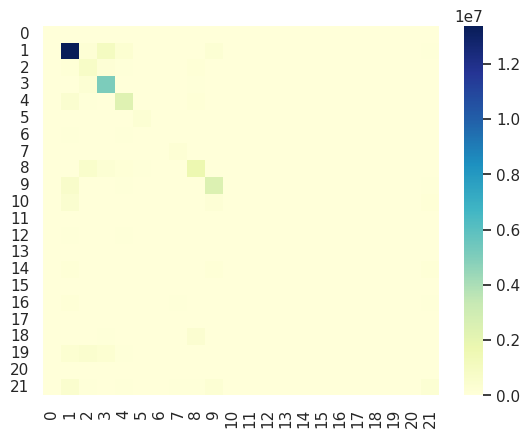

In [29]:
import seaborn as sns
sns.set_theme()

ax = sns.heatmap(df_cm, annot_kws={"size": 10}, fmt=".1f", cmap="YlGnBu")

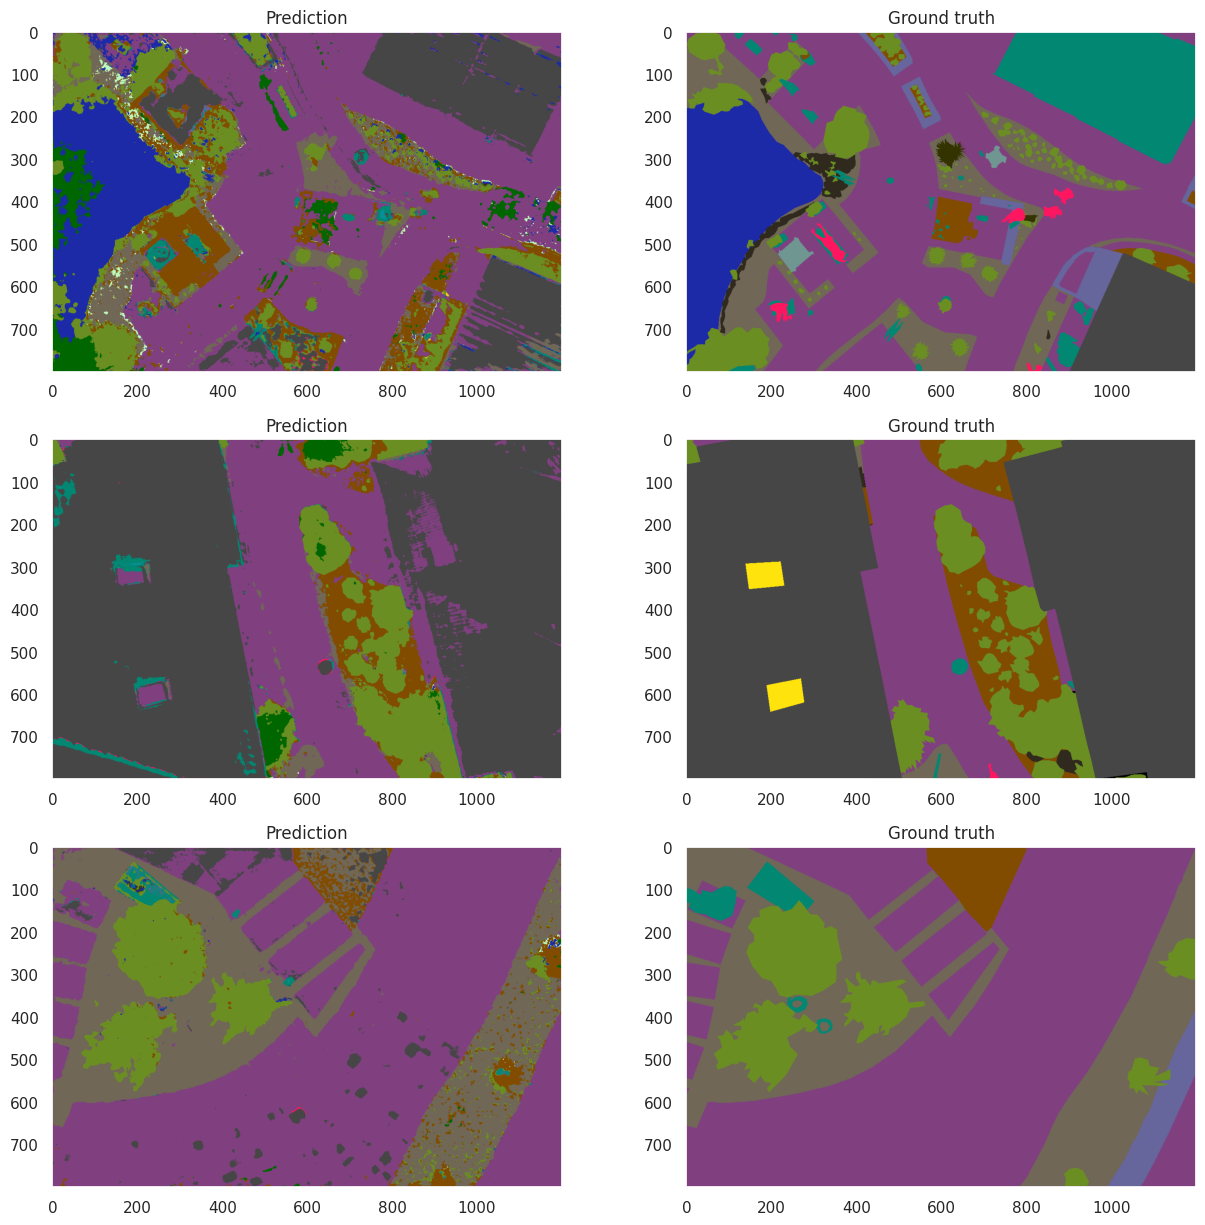

In [31]:
cmap = np.array(list(df[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 1200)
label = label.reshape(-1, 800, 1200)

i = 18

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(cmap[predictions[i+j]])
    ax[j, 1].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
    ax[j, 0].grid(False)
    ax[j, 1].grid(False)
    
plt.show()